**BASELINE MODEL: CHURN PREDICTION**

**Import libraries**

In [1]:
import pandas as pd
import pandas_profiling as pp
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split


# Work with data

**Load data**

In [8]:
train = pd.read_csv("../data/train.csv", engine='c', sep=',', low_memory=False)
cat_columns = train.select_dtypes(exclude=[np.number]).columns
object_cols = {}
for col in cat_columns:
        object_cols[col] = 'str'
object_cols['zip']='str'

train = pd.read_csv("../data/train.csv", engine='c', sep=',', dtype=object_cols)
responders = train["Responders"].values
train.drop("Responders", axis=1, inplace=True)
#train.drop("UCIC_ID", axis=1, inplace=True)


x_train, x_test, y_train, y_test = train_test_split(train, responders, test_size=0.2, random_state=0)

id_train=x_train["UCIC_ID"].values
id_test=x_test["UCIC_ID"].values

x_train=x_train.copy()
x_train.drop("UCIC_ID", axis=1, inplace=True)
y_train=y_train.copy()
x_test=x_test.copy()
x_test.drop("UCIC_ID", axis=1, inplace=True)
y_test=y_test.copy()


In [9]:
type(x_train)

pandas.core.frame.DataFrame

In [ ]:
#pp.ProfileReport(train[train.columns[:100]])

In [ ]:
#pp.ProfileReport(train[['zip', 'city']])


**Clean data**

In [ ]:
#for df in [train, test]:
#    df.drop('city', axis = 1, inplace=True)

In [ ]:
#for df in [train, test]:
#    df['zip1']=df['zip'].str[:2]
#    df['zip2']=df['zip'].str[:3]
#    df.drop('zip', axis = 1, inplace=True)
    

**Deal with cathegorical features. Encoding**


In [10]:
from collections import defaultdict
d = defaultdict(LabelEncoder)

cat_columns = x_train.select_dtypes(exclude=[np.number]).columns

# fit and encode train/test
a = pd.concat([x_train[cat_columns], x_test[cat_columns]], axis=0).fillna('').apply(lambda x: d[x.name].fit(x))

# transform encodings to train
x_train[cat_columns] = x_train[cat_columns].fillna('').apply(lambda x: d[x.name].transform(x))

# transform encodings to test
x_test[cat_columns] = x_test[cat_columns].fillna('').apply(lambda x: d[x.name].transform(x))

# Model

**Train model**

In [11]:
import lightgbm as lgb

lgb_train = lgb.Dataset(x_train, y_train)


params = {
    'application': 'binary',
    'num_leaves':256,
    'feature_fraction': 0.9,
    'sub_row': 0.9,
    #'min_data_in_leaf': 50,
    'bagging_freq': 1,
    'max_bin': 256,
    #'metric': 'auc',
    'metric': ('l1', 'l2'),
    'num_threads': 4,
    'verbose': 0,
    'seed': 42,
    'keep_training_booster': False
}


print('Start training...')

model = lgb.train(params, lgb_train, num_boost_round=100)

print('Training finished.')


Start training...
Training finished.


**Plot feature importance**

Plot feature importances...


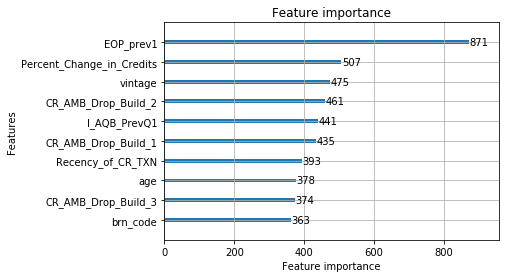

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

print('Plot feature importances...')
ax = lgb.plot_importance(model, max_num_features=10)
#plt.show()

# Test on train data

In [39]:
def lift(df, percentage=0.2):
    return df.sort_values('prediction', ascending=False).iloc[:int(len(df)*percentage)]["Responders"].sum()/df["Responders"].sum()


validation1=pd.DataFrame()
validation1["UCIC_ID"]=id_train
validation1["Responders"]=y_train
validation1["prediction"]=model.predict(x_train)

print(sum(validation1["Responders"]))

print(validation1.sort_values("prediction", ascending =False)[:48000]["Responders"].sum())

print(34620/41358)

print('Lift meric = ', lift(validation1))

SyntaxError: invalid syntax (<ipython-input-39-4a63b4f04197>, line 2)

# Test on test subsumpling

In [30]:
validation2=pd.DataFrame()
validation2["UCIC_ID"]=id_test
validation2["Responders"]=y_test
validation2["prediction"]=model.predict(x_test)


print(sum(validation2["Responders"]))

print(sum(validation2.sort_values("prediction", ascending =False)[:12000]["Responders"]))

10339
6965


# Predict test

In [ ]:
submission = pd.read_csv("../data/sample_submission.csv")

test["Responders"] = model.predict(test)
test[submission.columns].to_csv("../predictions/baseline_4.csv", index=False)

In [ ]:
#test[submission.columns]